# 0. Install Dependencies

In [ ]:
!pip install tensorflow==2.3.1 gym keras-rl2 gym[atari,accept-rom-license]
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
# install required system dependencies for DQN
!apt-get install -y xvfb x11-utils
# install required python dependencies for DQN
!pip install gym[box2d]==0.17.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*


- ATTENTION !!!:  
  PENSEZ A BIEN REDEMARRER VOTRE RUNTIME  
  (cliquer sur Restart ou Redémarrer à la fin du process précédent)

# Download the [ROM](https://fr.wikipedia.org/wiki/Image_ROM)

In [2]:
import urllib.request
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
!pip install unrar


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Unpack The ROM

* The next cell can sometimes display an inline dialog Box<br>
* in that case Insert "A" in the cell field and hit Enter 

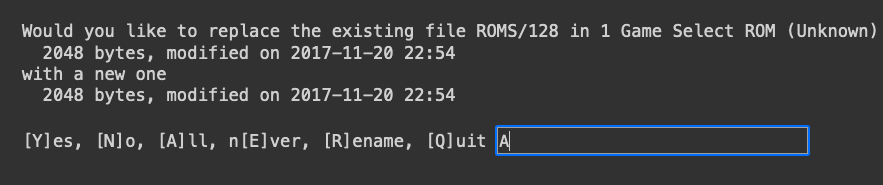

In [ ]:
!unrar x Roms.rar

In [ ]:
!python -m atari_py.import_roms "ROMS"

# 1. Test OpenAI Gym Environment 

In [19]:
import gym 
import random

In [20]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [21]:
env = wrap_env(gym.make('SpaceInvaders-v0'))
height, width, channels = env.observation_space.shape
actions = env.action_space.n

In [22]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

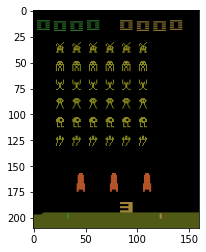

In [23]:
from pyvirtualdisplay import Display
Display().start()

from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

img = plt.imshow(env.render('rgb_array')) # only call this once

In [24]:
episodes = 5

show_image = False # Passer ce paramètre à False pour aller plus vite sans afficher l'image

for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        if show_image :
          screen = env.render(mode='rgb_array')
          plt.imshow(screen)  
          display.clear_output(wait=True)
          display.display(plt.gcf())      
        action = random.choice([0,1,2,3,4,5])
        n_state, reward, done, info = env.step(action)
        score+=reward
        
    print('Episode:{} Score:{}'.format(episode, score))
env.close()

Episode:1 Score:45.0
Episode:2 Score:270.0
Episode:3 Score:260.0
Episode:4 Score:180.0
Episode:5 Score:45.0


In [11]:
show_video()

# 2. Create a Deep Learning Model with Keras

In [25]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Convolution2D
from tensorflow.keras.optimizers import Adam

In [26]:
def build_model(height, width, channels, actions):
    model = Sequential()
    model.add(Convolution2D(32, (8,8), strides=(4,4), activation='relu', input_shape=(3,height, width, channels)))
    model.add(Convolution2D(64, (4,4), strides=(2,2), activation='relu'))
    model.add(Convolution2D(64, (3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [31]:
# CAUTION
# run this ONLY to solve "ValueError: Tensor must be from the same graph as Tensor" tha will occur on cell 24
# and rebuild the model (run all subsequent cells)
del model

In [32]:
model = build_model(height, width, channels, actions)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 3, 51, 39, 32)     6176      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 24, 18, 64)     32832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 22, 16, 64)     36928     
_________________________________________________________________
flatten (Flatten)            (None, 67584)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               34603520  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1

# 3. Build Agent with Keras-RL

In [28]:
from rl.agents import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy

In [33]:
def build_agent(model, actions):
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.2, nb_steps=10000)
    memory = SequentialMemory(limit=1000, window_length=3)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                   enable_dueling_network=True, dueling_type='avg', 
                   nb_actions=actions, nb_steps_warmup=1000)
    return dqn

In [34]:
# CAUTION : This cell does not play nice 
# it throws "ValueError: Tensor must be from the same graph as Tensor"
# go back to the "del model" cell and rerun all the cells in between to rebuild the model
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-4))

In [35]:
dqn.fit(env, nb_steps=1000, visualize=False, verbose=2)

Training for 5 steps ...
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
done, took 0.611 seconds


In [36]:
# Stats : 1mn per episode
scores = dqn.test(env, nb_episodes=15, visualize=True)
print(np.mean(scores.history['episode_reward']))

Testing for 3 episodes ...
Episode 1: reward: 210.000, steps: 935
Episode 2: reward: 345.000, steps: 1256
Episode 3: reward: 285.000, steps: 868
280.0


# 4. Reloading Agent from Memory

In [21]:
dqn.save_weights('SavedWeights/10k-Fast/dqn_weights.h5f')

In [22]:
del model

In [ ]:
dqn.load_weights('SavedWeights/1m/dqn_weights.h5f')